### Imprting the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

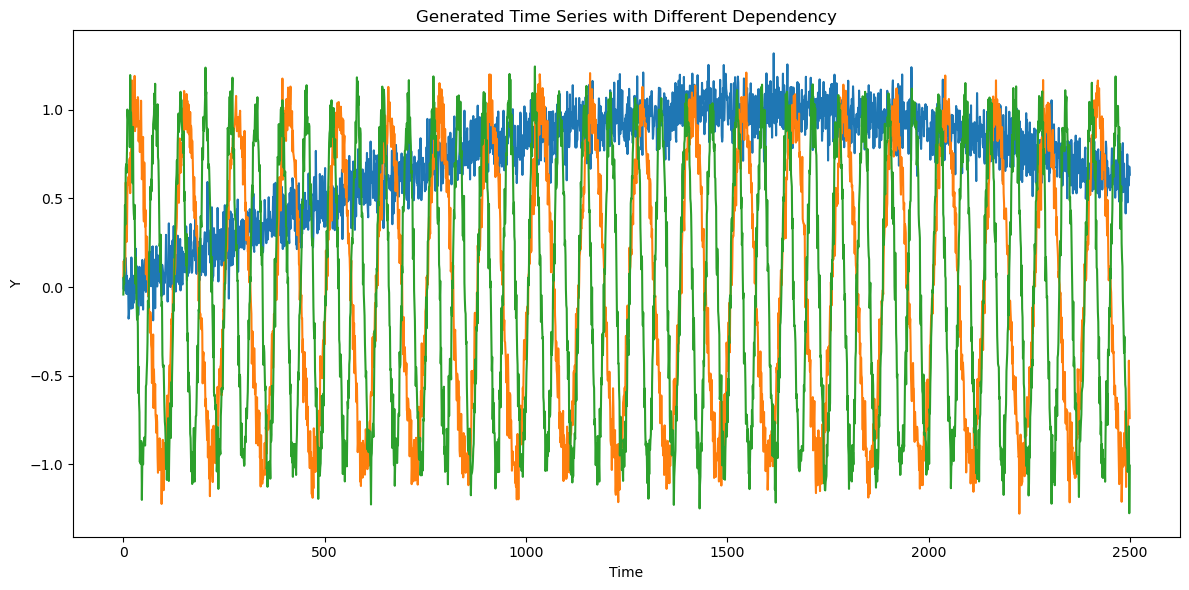

In [53]:
# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic time series data
def generate_time_series(n_points=2500):
    t = np.arange(n_points)

    # Long-term dependency: sinusoidal with low frequency
    long_term = np.sin(0.001 * t) + 0.1 * np.random.randn(n_points)

    # Mid-term dependency: sinusoidal with medium frequency
    mid_term = np.sin(0.05 * t) + 0.1 * np.random.randn(n_points)

    # Short-term dependency: high frequency
    short_term = np.sin(0.1 * t) + 0.1 * np.random.randn(n_points)

    return long_term, mid_term, short_term

# Generate data
long_term, mid_term, short_term = generate_time_series()

# Plot the generated time series
plt.figure(figsize=(12, 6))
plt.plot(long_term, label='Long-term Dependency')
plt.plot(mid_term, label='Mid-term Dependency')
plt.plot(short_term, label='Short-term Dependency')
plt.title("Generated Time Series with Different Dependency")
plt.xlabel('Time')
plt.ylabel('Y')
# plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig('Input_signals.png', transparent=True)
plt.show()


### Functions to preprocess data and training the model

In [ ]:
# Fix seed
np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic time series
def generate_time_series(n=10000):
    t = np.arange(n)
    long = np.sin(0.001 * t) + 0.2 * np.random.randn(n)
    mid = np.sin(0.05 * t) + 0.2 * np.random.randn(n)
    short = np.sin(0.1 * t) + 0.2 * np.random.randn(n)
    return long, mid, short

# Prepare sequences
def create_dataset(data, window_size=40):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # [samples, time, 1]
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    return TensorDataset(X, y)

# Define models
class RNNModel(nn.Module):
    def __init__(self, rnn_type='RNN'):
        super().__init__()
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn = rnn_cls(input_size=1, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# Train and evaluate
def train_model(model, train_loader, val_loader, epochs=30):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(np.mean(batch_losses))
    return train_losses

# Compare models
def evaluate_models(series, label):
    dataset = create_dataset(series)
    train_size = int(0.8 * len(dataset))
    train_data, val_data = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)

    results = {}
    for rnn_type in ['RNN', 'LSTM', 'GRU']:
        model = RNNModel(rnn_type)
        start = time.time()
        losses = train_model(model, train_loader, val_loader)
        duration = time.time() - start
        model.eval()
        with torch.no_grad():
            val_loss = sum((model(xb) - yb).pow(2).sum().item() for xb, yb in val_loader) / len(val_data)
        results[rnn_type] = {'losses': losses, 'val_loss': val_loss, 'time': duration}
    return results

### Execution

In [ ]:
# Main execution
long, mid, short = generate_time_series()
datasets = {'Long-term': long, 'Mid-term': mid, 'Short-term': short}
final_results = {}

for label, data in datasets.items():
    print(f"Training on {label} dependency...")
    final_results[label] = evaluate_models(data, label)

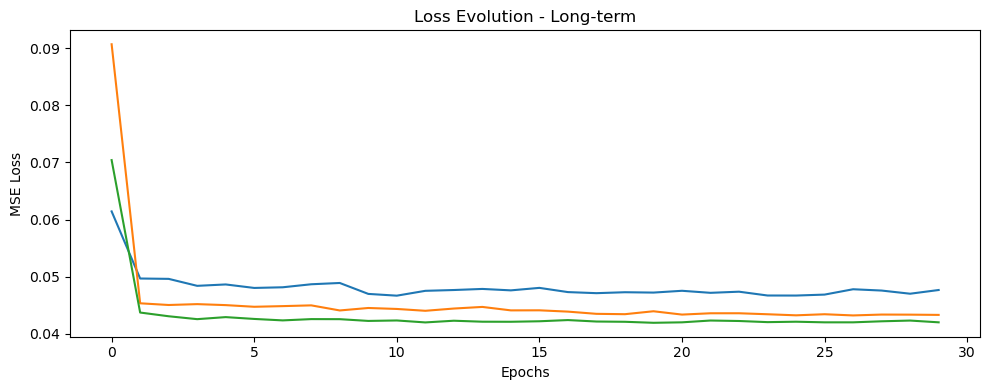

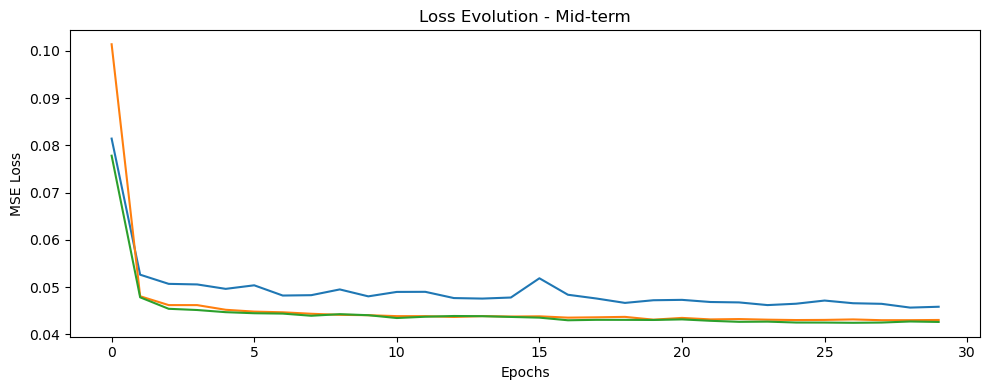

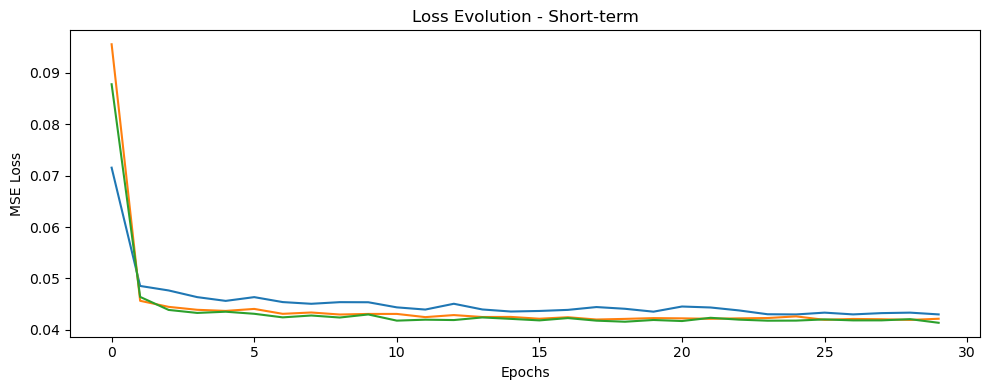

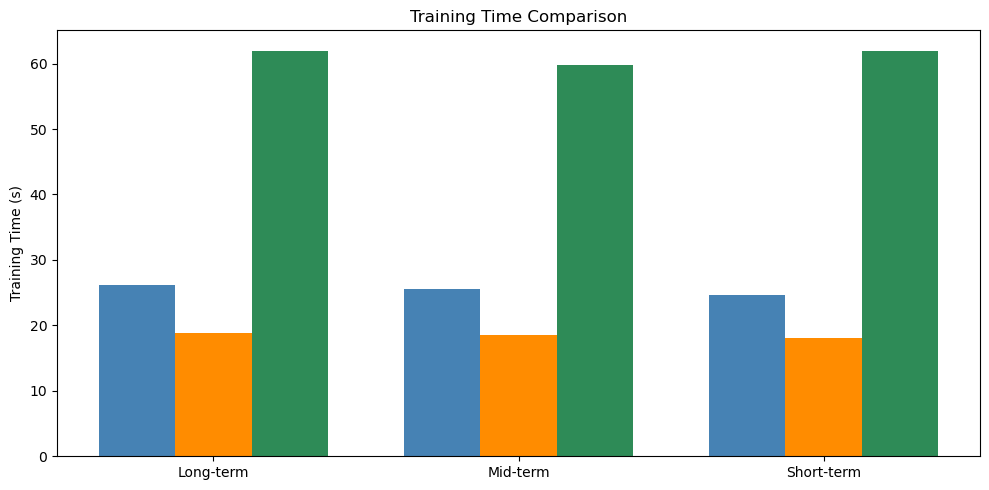

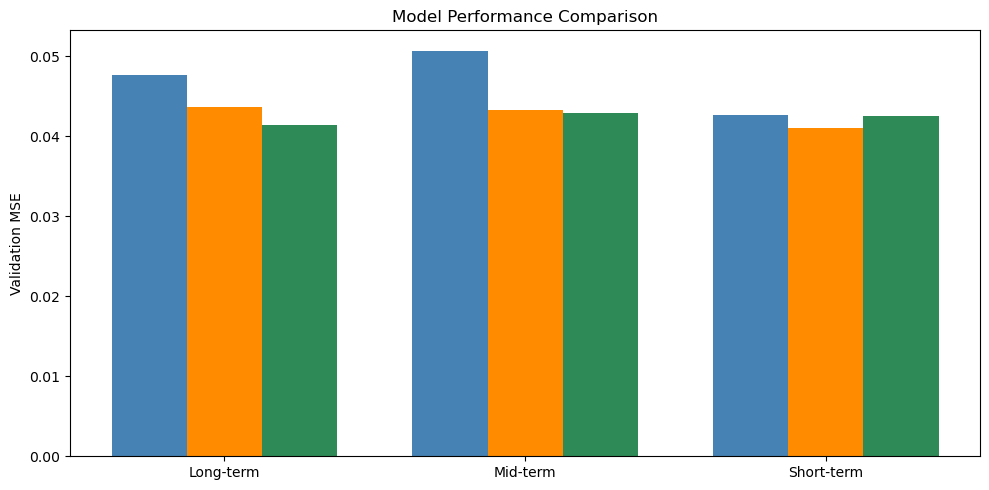

In [57]:
# Plotting
for label in datasets:
    plt.figure(figsize=(10, 4))
    for model in ['RNN', 'LSTM', 'GRU']:
        plt.plot(final_results[label][model]['losses'], label=model)
    plt.title(f"Loss Evolution - {label}")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    # plt.legend()
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{label}_training.png', transparent=True)
    plt.show()

# Training Time Plot
labels = list(datasets.keys())
model_types = ['RNN', 'LSTM', 'GRU']
training_times = [[final_results[label][model]['time'] for label in labels] for model in model_types]

x = np.arange(len(labels))
width = 0.25

# Define colors for each model
model_colors = {
    'RNN': 'steelblue',
    'LSTM': 'darkorange',
    'GRU': 'seagreen'
}

plt.figure(figsize=(10, 5))
for i, model in enumerate(model_types):
    plt.bar(x + i * width, training_times[i], width, label=model, color=model_colors[model])
plt.xticks(x + width, labels)
plt.ylabel("Training Time (s)")
plt.title("Training Time Comparison")
# plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig(f'Time.png', transparent=True)
plt.show()

# Final Performance Plot (Validation MSE)
val_mse = [[final_results[label][model]['val_loss'] for label in labels] for model in model_types]
plt.figure(figsize=(10, 5))
for i, model in enumerate(model_types):
    plt.bar(x + i * width, val_mse[i], width, label=model, color=model_colors[model])
plt.xticks(x + width, labels)
plt.ylabel("Validation MSE")
plt.title("Model Performance Comparison")
# plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig(f'Performance.png', transparent=True)
plt.show()
